## Ansatz code

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import time


## VQE Approach

MaxCut Solver with Dynamic EfficientSU2 Ansatz
Using scipy.optimize.minimize with COBYLA


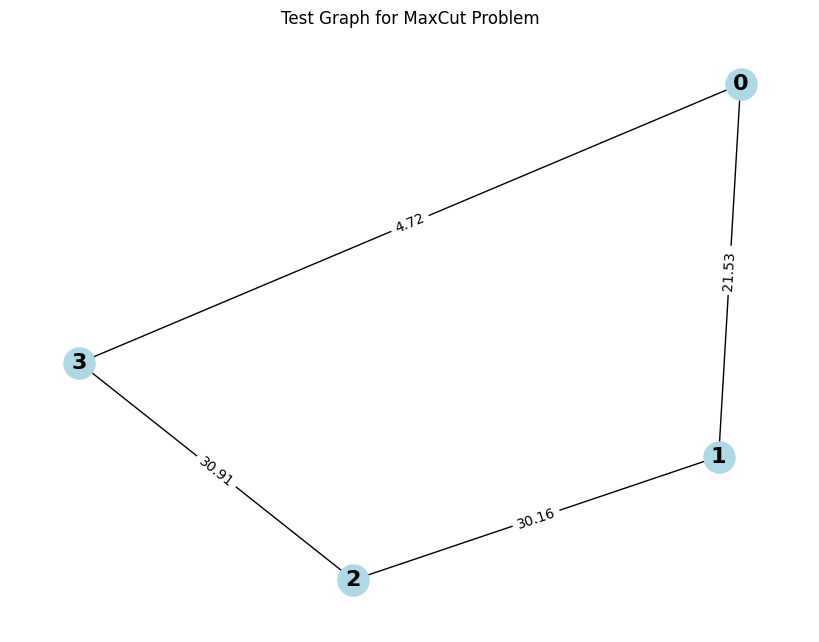

Solving MaxCut for 4-qubit graph
Graph has 4 edges
Running 20 iterations with cycling entanglement
Using scipy.optimize.minimize with COBYLA method

Iteration 1: Entangling qubits 0 and 1
  Optimization time: 0.53s
  Cost: -87.320015
  Function evaluations: 100
  Success: False
  Message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
  *** New best result! ***

Iteration 2: Entangling qubits 1 and 2
  Optimization time: 0.45s
  Cost: -87.320017
  Function evaluations: 100
  Success: False
  Message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
  *** New best result! ***

Iteration 3: Entangling qubits 2 and 3
  Optimization time: 0.48s
  Cost: -87.320018
  Function evaluations: 100
  Success: False
  Message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
  *** New best result! ***

Iteration 4: Entangling qubits 0 and 1
  Optimization time: 0.50s
  Cost: -87.320017
  Function

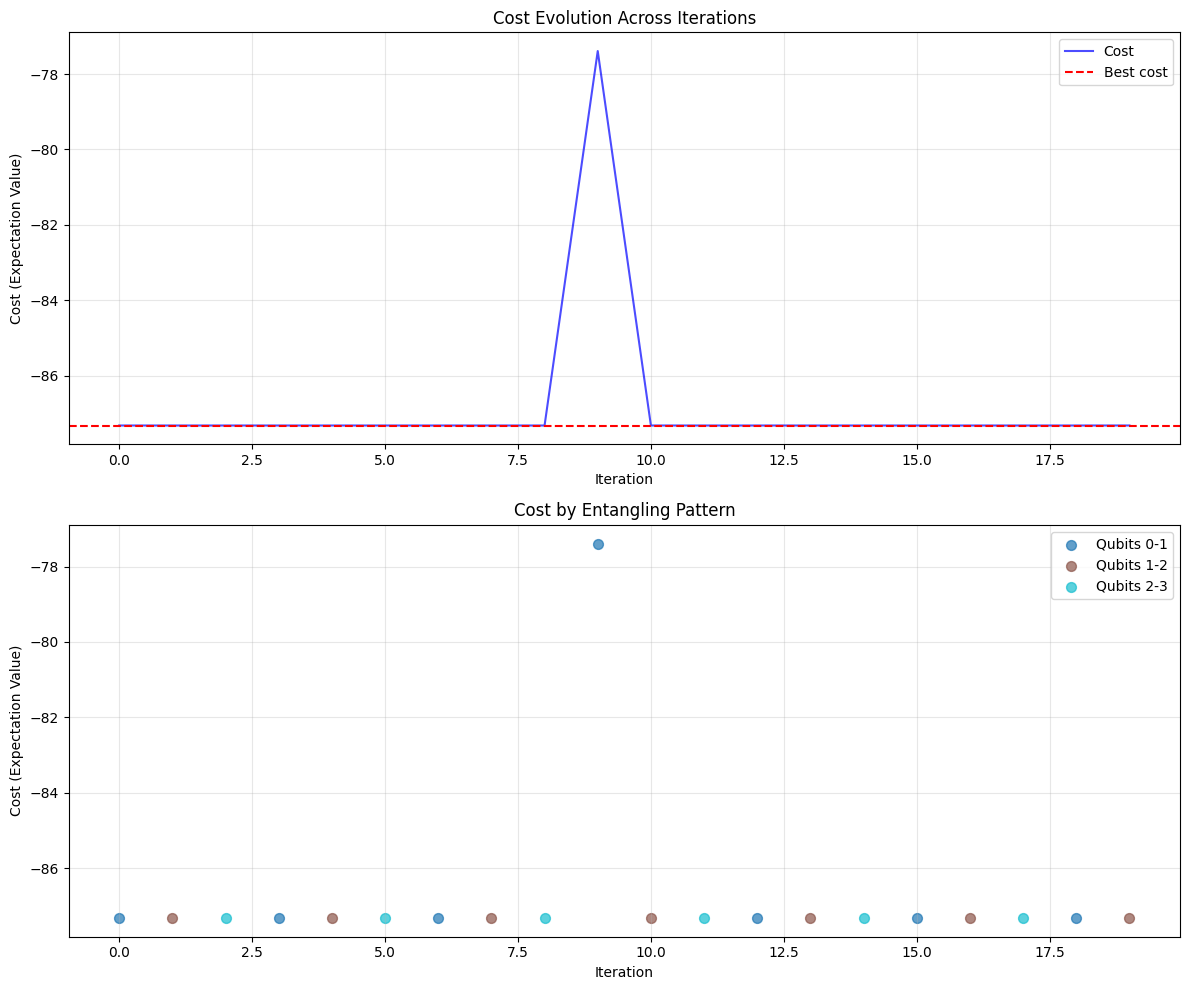


SUMMARY STATISTICS:
Total iterations: 20
Best cost: -87.320018
Worst cost: -77.391520
Average cost: -86.823552
Standard deviation: 2.163857
Total function evaluations: 2000
Average function evaluations per iteration: 100.0
Total optimization time: 9.20s
Average optimization time per iteration: 0.46s

PERFORMANCE BY ENTANGLING PATTERN:
Qubits 0-1: Best=-87.320018, Avg=-85.901656, Count=7
Qubits 1-2: Best=-87.320018, Avg=-87.319908, Count=7
Qubits 2-3: Best=-87.320018, Avg=-87.320017, Count=6


In [3]:
class MaxCutDynamicSolver:
    def __init__(self, graph, num_reps=1, max_iterations=100):
        """
        Initialize the MaxCut solver with dynamic EfficientSU2 ansatz.
        
        Args:
            graph: NetworkX graph or adjacency matrix
            num_reps: Number of repetitions of the ansatz layers
            max_iterations: Maximum number of iterations to cycle through entangling patterns
        """
        if isinstance(graph, np.ndarray):
            # Convert adjacency matrix to NetworkX graph
            self.graph = nx.from_numpy_array(graph)
        else:
            self.graph = graph
            
        self.num_qubits = len(self.graph.nodes())
        self.num_reps = num_reps
        self.max_iterations = max_iterations
        self.total_pairs = max(1, self.num_qubits - 1)
        
        # Create the MaxCut Hamiltonian
        self.hamiltonian = self._create_maxcut_hamiltonian()
        
        # Store results for each iteration
        self.results = []
        self.best_result = None
        self.best_iteration = 0
        
        # Initialize estimator for expectation value calculations
        self.estimator = Estimator()
        
        # Counter for function evaluations
        self.func_evals = 0
        
    def _create_maxcut_hamiltonian(self):
        """Create the MaxCut Hamiltonian from the graph."""
        pauli_list = []
        
        for edge in self.graph.edges():
            i, j = edge
            weight = self.graph[i][j].get('weight', 1.0)
            
            # Add -0.5 * weight * (I - ZiZj) for each edge
            # This is equivalent to 0.5 * weight * (ZiZj - I)
            pauli_str = ['I'] * self.num_qubits
            pauli_str[i] = 'Z'
            pauli_str[j] = 'Z'
            pauli_list.append((''.join(pauli_str), 0.5 * weight))
            
            # Add constant term -0.5 * weight for each edge
            pauli_list.append(('I' * self.num_qubits, -0.5 * weight))
            
        return SparsePauliOp.from_list(pauli_list)
    
    def create_ansatz(self, entangling_pair_index):
        """Create the ansatz circuit for a specific entangling pattern."""
        qc = QuantumCircuit(self.num_qubits)
        
        # Calculate which qubits to entangle
        if self.num_qubits <= 1:
            pair_idx = 0
            qubit1, qubit2 = 0, 0
        else:
            pair_idx = entangling_pair_index % self.total_pairs
            qubit1 = pair_idx
            qubit2 = pair_idx + 1
        
        # Create parameters
        parameters = []
        
        for rep in range(self.num_reps):
            # Add rotation gates to all qubits
            for i in range(self.num_qubits):
                theta_y = Parameter(f'θ_{rep}_{i}_y')
                theta_z = Parameter(f'θ_{rep}_{i}_z')
                parameters.extend([theta_y, theta_z])
                
                qc.ry(theta_y, i)
                qc.rz(theta_z, i)
            
            # Add entangling gate (only if we have more than 1 qubit)
            if self.num_qubits > 1:
                qc.cx(qubit1, qubit2)
        
        return qc, parameters
    
    def cost_function(self, parameters, ansatz, hamiltonian, estimator):
        """Cost function for the MaxCut problem using Estimator primitive.
        
        Parameters:
            parameters (ndarray): Array of ansatz parameters
            ansatz (QuantumCircuit): Parameterized ansatz circuit
            hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
            estimator (Estimator): Estimator primitive instance
        
        Returns:
            float: Energy estimate
        """
        self.func_evals += 1
        
        # Use the new Qiskit 1.0+ syntax with publications
        pub = (ansatz, hamiltonian, parameters)
        job = estimator.run([pub])
        result = job.result()
        expectation_value = result[0].data.evs  # Remove [0] index - evs is already a scalar
        
        return expectation_value
    
    def get_cut_value(self, bitstring):
        """Calculate the cut value for a given bitstring."""
        cut_value = 0
        for edge in self.graph.edges():
            i, j = edge
            weight = self.graph[i][j].get('weight', 1.0)
            if bitstring[i] != bitstring[j]:
                cut_value += weight
        return cut_value
    
    def sample_solutions(self, ansatz, optimal_parameters, shots=1000):
        """Sample solutions from the optimized circuit."""
        from qiskit import ClassicalRegister
        
        # Create a copy of the circuit for measurement
        measurement_circuit = ansatz.copy()
        
        # Assign optimal parameters (Qiskit 1.0+ syntax)
        bound_circuit = measurement_circuit.assign_parameters(optimal_parameters)
        
        # Add measurements
        bound_circuit.add_register(ClassicalRegister(self.num_qubits, 'c'))
        bound_circuit.measure_all()
        
        # Initialize sampler for measurements
        sampler = Sampler()
        
        # Run sampling
        job = sampler.run([bound_circuit], shots=shots)
        result = job.result()
        counts = result[0].data.meas.get_counts()
        
        # Analyze results
        cut_values = {}
        for bitstring, count in counts.items():
            cut_value = self.get_cut_value([int(b) for b in bitstring])
            cut_values[bitstring] = {'cut_value': cut_value, 'count': count}
        
        return cut_values
    
    def solve(self, shots=1000, verbose=True, maxiter=100):
        """
        Solve the MaxCut problem using dynamic entangling patterns.
        
        Args:
            shots: Number of shots for final sampling
            verbose: Whether to print progress
            maxiter: Maximum iterations for scipy optimizer
        """
        if verbose:
            print(f"Solving MaxCut for {self.num_qubits}-qubit graph")
            print(f"Graph has {len(self.graph.edges())} edges")
            print(f"Running {self.max_iterations} iterations with cycling entanglement")
            print(f"Using scipy.optimize.minimize with COBYLA method")
            print("="*80)
        
        best_cost = float('inf')
        best_parameters = None
        best_ansatz = None
        
        for iteration in range(self.max_iterations):
            if verbose:
                pair_idx = iteration % self.total_pairs
                if self.num_qubits > 1:
                    print(f"\nIteration {iteration + 1}: Entangling qubits {pair_idx} and {pair_idx + 1}")
                else:
                    print(f"\nIteration {iteration + 1}: Single qubit (no entanglement)")
            
            # Create ansatz for this iteration
            ansatz, parameters = self.create_ansatz(iteration)
            
            # Initialize parameters randomly
            x0 = np.random.uniform(0, 2*np.pi, len(parameters))
            
            # Reset function evaluation counter
            self.func_evals = 0
            
            # Define cost function for scipy.optimize.minimize
            def cost_func(params, ansatz, hamiltonian, estimator):
                return self.cost_function(params, ansatz, hamiltonian, estimator)
            
            # Optimize using scipy.optimize.minimize
            start_time = time.time()
            res = minimize(
                cost_func,
                x0,
                args=(ansatz, self.hamiltonian, self.estimator),
                method="COBYLA",
                options={'maxiter': maxiter, 'disp': False}
            )
            optimization_time = time.time() - start_time
            
            # Store results for this iteration
            self.results.append({
                'iteration': iteration,
                'entangling_pair': iteration % self.total_pairs,
                'expectation_value': res.fun,
                'parameters': res.x.copy(),
                'success': res.success,
                'nfev': res.nfev,
                'optimization_time': optimization_time
            })
            
            if verbose:
                print(f"  Optimization time: {optimization_time:.2f}s")
                print(f"  Cost: {res.fun:.6f}")
                print(f"  Function evaluations: {res.nfev}")
                print(f"  Success: {res.success}")
                if hasattr(res, 'message'):
                    print(f"  Message: {res.message}")
            
            # Track best result
            if res.fun < best_cost:
                best_cost = res.fun
                best_parameters = res.x
                best_ansatz = ansatz
                self.best_iteration = iteration
                
                if verbose:
                    print(f"  *** New best result! ***")
        
        # Store best result
        self.best_result = {
            'cost': best_cost,
            'parameters': best_parameters,
            'ansatz': best_ansatz,
            'iteration': self.best_iteration
        }
        
        if verbose:
            print(f"\n" + "="*80)
            print(f"OPTIMIZATION COMPLETE")
            print(f"Best result from iteration {self.best_iteration + 1}")
            print(f"Best cost: {best_cost:.6f}")
            print(f"MaxCut value: {-best_cost:.6f}")  # Negative because we minimize
        
        return self.best_result
    
    def analyze_results(self):
        """Analyze and visualize the optimization results."""
        if not self.results:
            print("No results to analyze. Run solve() first.")
            return
        
        # Extract data for plotting
        iterations = [r['iteration'] for r in self.results]
        costs = [r['expectation_value'] for r in self.results]
        entangling_pairs = [r['entangling_pair'] for r in self.results]
        nfevs = [r['nfev'] for r in self.results]
        times = [r['optimization_time'] for r in self.results]
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot cost evolution
        ax1.plot(iterations, costs, 'b-', alpha=0.7, label='Cost')
        ax1.axhline(y=min(costs), color='r', linestyle='--', label='Best cost')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Cost (Expectation Value)')
        ax1.set_title('Cost Evolution Across Iterations')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot entangling patterns
        colors = plt.cm.tab10(np.linspace(0, 1, self.total_pairs))
        for pair_idx in range(self.total_pairs):
            pair_iterations = [i for i, p in zip(iterations, entangling_pairs) if p == pair_idx]
            pair_costs = [c for c, p in zip(costs, entangling_pairs) if p == pair_idx]
            
            if self.num_qubits > 1:
                label = f'Qubits {pair_idx}-{pair_idx+1}'
            else:
                label = 'Single qubit'
            
            ax2.scatter(pair_iterations, pair_costs, color=colors[pair_idx], 
                       label=label, alpha=0.7, s=50)
        
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Cost (Expectation Value)')
        ax2.set_title('Cost by Entangling Pattern')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nSUMMARY STATISTICS:")
        print(f"Total iterations: {len(self.results)}")
        print(f"Best cost: {min(costs):.6f}")
        print(f"Worst cost: {max(costs):.6f}")
        print(f"Average cost: {np.mean(costs):.6f}")
        print(f"Standard deviation: {np.std(costs):.6f}")
        print(f"Total function evaluations: {sum(nfevs)}")
        print(f"Average function evaluations per iteration: {np.mean(nfevs):.1f}")
        print(f"Total optimization time: {sum(times):.2f}s")
        print(f"Average optimization time per iteration: {np.mean(times):.2f}s")
        
        # Performance by entangling pattern
        print("\nPERFORMANCE BY ENTANGLING PATTERN:")
        for pair_idx in range(self.total_pairs):
            pair_costs = [c for c, p in zip(costs, entangling_pairs) if p == pair_idx]
            if pair_costs:
                if self.num_qubits > 1:
                    print(f"Qubits {pair_idx}-{pair_idx+1}: "
                          f"Best={min(pair_costs):.6f}, "
                          f"Avg={np.mean(pair_costs):.6f}, "
                          f"Count={len(pair_costs)}")
                else:
                    print(f"Single qubit: "
                          f"Best={min(pair_costs):.6f}, "
                          f"Avg={np.mean(pair_costs):.6f}, "
                          f"Count={len(pair_costs)}")

# Example usage and testing
def create_test_graph(num_nodes=4, graph_type='complete'):
    """Create test graphs for MaxCut problem."""
    if graph_type == 'complete':
        G = nx.complete_graph(num_nodes)
    elif graph_type == 'cycle':
        G = nx.cycle_graph(num_nodes)
    elif graph_type == 'path':
        G = nx.path_graph(num_nodes)
    elif graph_type == 'random':
        G = nx.erdos_renyi_graph(num_nodes, 0.5, seed=42)
    else:
        raise ValueError(f"Unknown graph type: {graph_type}")
    
    # Add random weights
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = np.random.uniform(1, 50)
    
    return G

def run_maxcut_example():
    """Run a complete MaxCut example."""
    print("MaxCut Solver with Dynamic EfficientSU2 Ansatz")
    print("Using scipy.optimize.minimize with COBYLA")
    print("="*50)
    
    # Create test graph
    graph = create_test_graph(num_nodes=4, graph_type='cycle')
    
    # Initialize solver
    solver = MaxCutDynamicSolver(graph, num_reps=1, max_iterations=20)
    
    # Visualize the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=16, font_weight='bold')
    
    # Draw edge labels with weights
    edge_labels = {edge: f"{graph[edge[0]][edge[1]]['weight']:.2f}" 
                   for edge in graph.edges()}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    
    plt.title("Test Graph for MaxCut Problem")
    plt.show()
    
    # Solve the problem
    result = solver.solve(verbose=True, maxiter=100)
    
    # Analyze results
    solver.analyze_results()
    
    return solver, result

if __name__ == "__main__":
    # Run example
    solver, result = run_maxcut_example()

## Brute Force solution

MaxCut Brute Force Solver


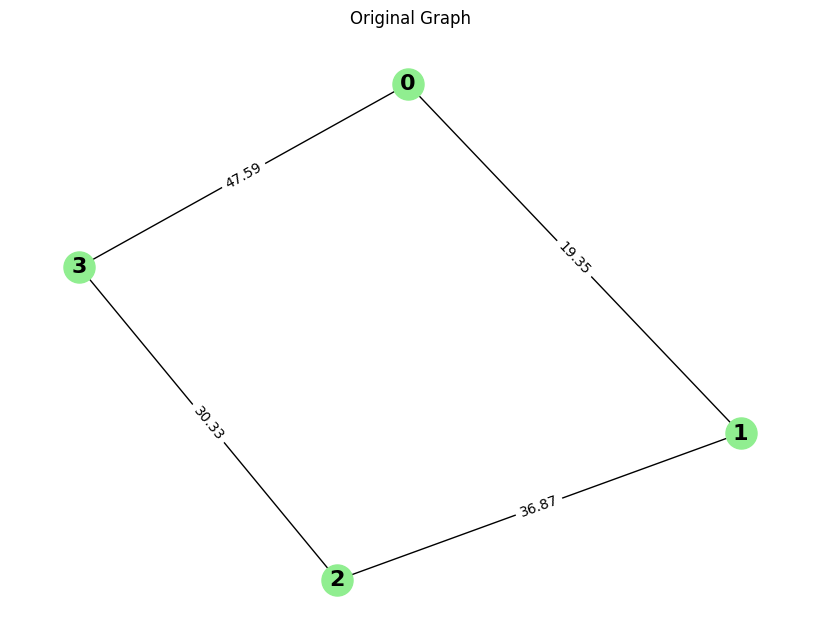

Solving MaxCut by Brute Force
Graph: 4 vertices, 4 edges
Total configurations to check: 2^4 = 16
New best: (0, 0, 0, 1) -> Cut = 77.9193
New best: (0, 0, 1, 1) -> Cut = 84.4527
New best: (0, 1, 0, 1) -> Cut = 134.1394

BRUTE FORCE SOLUTION COMPLETE
Solve time: 0.0001 seconds
Best cut value: 134.1394
Best assignment: (0, 1, 0, 1)
Best bitstring: 0101
Partition 0: [0, 2]
Partition 1: [1, 3]
Cut edges: 4
  (0, 1): weight = 19.3525
  (0, 3): weight = 47.5850
  (1, 2): weight = 36.8677
  (2, 3): weight = 30.3343

SOLUTION ANALYSIS:
Total solutions checked: 16
Best cut value: 134.1394
Worst cut value: 0.0000
Average cut value: 67.0697
Standard deviation: 35.0651
Number of optimal solutions: 2
All optimal solutions:
  0101: 134.1394
  1010: 134.1394


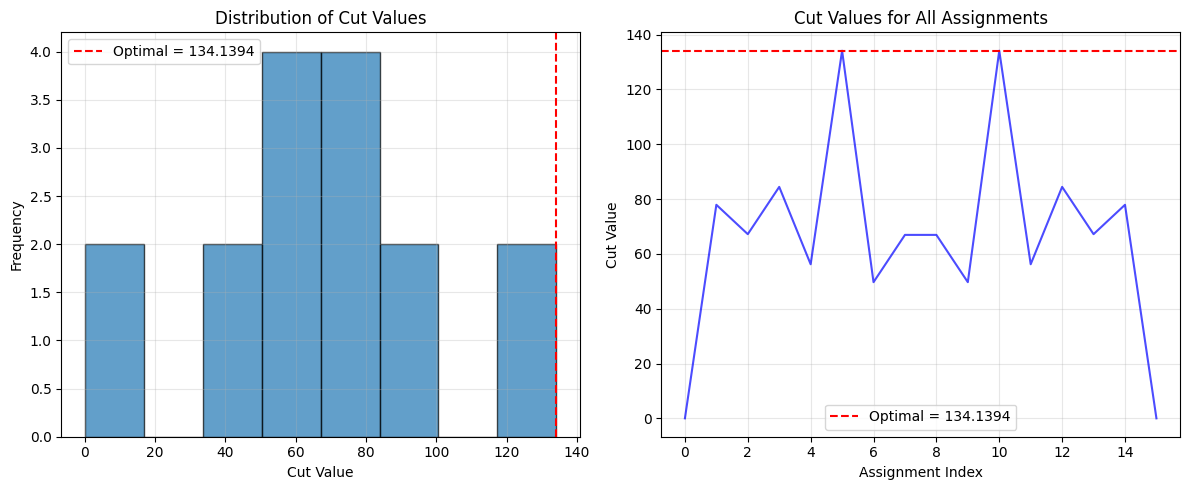

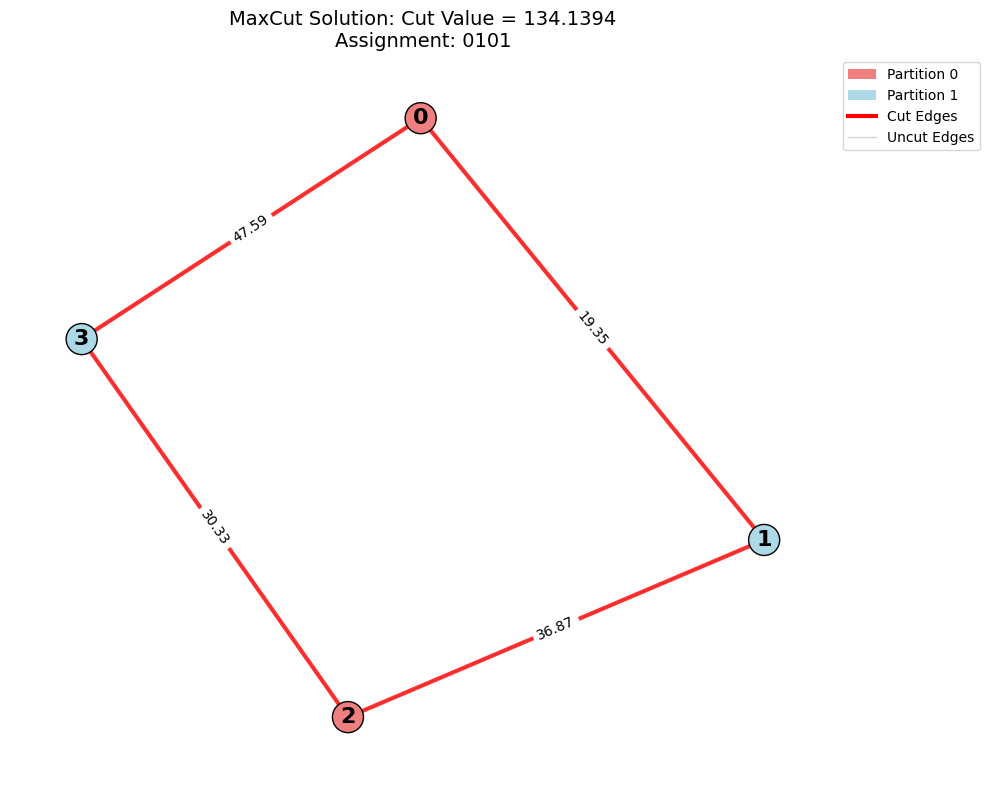


Testing with a cycle graph:
Solving MaxCut by Brute Force
Graph: 4 vertices, 6 edges
Total configurations to check: 2^4 = 16
New best: (0, 0, 0, 1) -> Cut = 54.1563
New best: (0, 0, 1, 0) -> Cut = 86.5630
New best: (0, 0, 1, 1) -> Cut = 123.4319

BRUTE FORCE SOLUTION COMPLETE
Solve time: 0.0001 seconds
Best cut value: 123.4319
Best assignment: (0, 0, 1, 1)
Best bitstring: 0011
Partition 0: [0, 1]
Partition 1: [2, 3]
Cut edges: 4
  (0, 2): weight = 47.5850
  (0, 3): weight = 36.8677
  (1, 2): weight = 30.3343
  (1, 3): weight = 8.6449


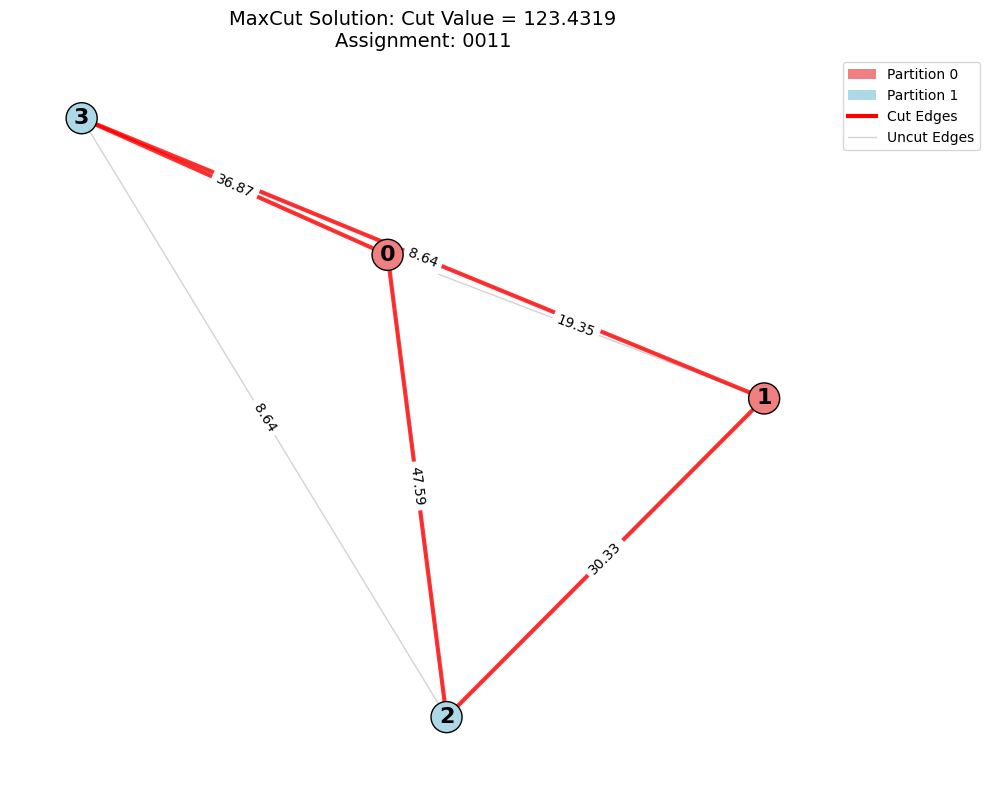

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
import time
from collections import defaultdict

class MaxCutBruteForce:
    def __init__(self, graph):
        """
        Initialize the brute force MaxCut solver.
        
        Args:
            graph: NetworkX graph or adjacency matrix
        """
        if isinstance(graph, np.ndarray):
            # Convert adjacency matrix to NetworkX graph
            self.graph = nx.from_numpy_array(graph)
        else:
            self.graph = graph
            
        self.num_qubits = len(self.graph.nodes())
        self.edges = list(self.graph.edges())
        self.edge_weights = {edge: self.graph[edge[0]][edge[1]].get('weight', 1.0) 
                           for edge in self.edges}
        
        # Store results
        self.all_solutions = []
        self.best_solution = None
        self.best_cut_value = 0
        
    def calculate_cut_value(self, assignment):
        """
        Calculate the cut value for a given assignment.
        
        Args:
            assignment: List or tuple of 0s and 1s representing the partition
            
        Returns:
            float: Cut value (sum of weights of edges crossing the cut)
        """
        cut_value = 0
        for edge in self.edges:
            i, j = edge
            weight = self.edge_weights[edge]
            
            # If vertices are in different partitions, edge is cut
            if assignment[i] != assignment[j]:
                cut_value += weight
                
        return cut_value
    
    def solve(self, verbose=True):
        """
        Solve MaxCut by brute force enumeration of all possible cuts.
        
        Args:
            verbose: Whether to print progress and results
            
        Returns:
            dict: Best solution with cut value and assignment
        """
        if verbose:
            print(f"Solving MaxCut by Brute Force")
            print(f"Graph: {self.num_qubits} vertices, {len(self.edges)} edges")
            print(f"Total configurations to check: 2^{self.num_qubits} = {2**self.num_qubits}")
            
            if self.num_qubits > 20:
                print("WARNING: Large graph! This might take a very long time...")
            
            print("="*60)
        
        start_time = time.time()
        
        # Generate all possible assignments (2^n possibilities)
        best_cut = 0
        best_assignment = None
        all_results = []
        
        # Use itertools.product to generate all binary combinations
        total_combinations = 2**self.num_qubits
        
        for i, assignment in enumerate(product([0, 1], repeat=self.num_qubits)):
            # Calculate cut value for this assignment
            cut_value = self.calculate_cut_value(assignment)
            
            # Store result
            all_results.append({
                'assignment': assignment,
                'cut_value': cut_value,
                'bitstring': ''.join(map(str, assignment))
            })
            
            # Track best solution
            if cut_value > best_cut:
                best_cut = cut_value
                best_assignment = assignment
                
                if verbose and self.num_qubits <= 10:
                    print(f"New best: {assignment} -> Cut = {cut_value:.4f}")
            
            # Progress update for large graphs
            if verbose and self.num_qubits > 10 and (i + 1) % (total_combinations // 10) == 0:
                progress = (i + 1) / total_combinations * 100
                print(f"Progress: {progress:.1f}% ({i+1}/{total_combinations})")
        
        solve_time = time.time() - start_time
        
        # Store results
        self.all_solutions = all_results
        self.best_solution = {
            'assignment': best_assignment,
            'cut_value': best_cut,
            'bitstring': ''.join(map(str, best_assignment)),
            'solve_time': solve_time
        }
        self.best_cut_value = best_cut
        
        if verbose:
            print(f"\n" + "="*60)
            print(f"BRUTE FORCE SOLUTION COMPLETE")
            print(f"Solve time: {solve_time:.4f} seconds")
            print(f"Best cut value: {best_cut:.4f}")
            print(f"Best assignment: {best_assignment}")
            print(f"Best bitstring: {''.join(map(str, best_assignment))}")
            self._print_partition_details(best_assignment)
        
        return self.best_solution
    
    def _print_partition_details(self, assignment):
        """Print details about the partition."""
        partition_0 = [i for i, val in enumerate(assignment) if val == 0]
        partition_1 = [i for i, val in enumerate(assignment) if val == 1]
        
        print(f"Partition 0: {partition_0}")
        print(f"Partition 1: {partition_1}")
        
        # Show which edges are cut
        cut_edges = []
        for edge in self.edges:
            i, j = edge
            if assignment[i] != assignment[j]:
                weight = self.edge_weights[edge]
                cut_edges.append((edge, weight))
        
        print(f"Cut edges: {len(cut_edges)}")
        for edge, weight in cut_edges:
            print(f"  {edge}: weight = {weight:.4f}")
    
    def analyze_results(self):
        """Analyze and visualize all solutions."""
        if not self.all_solutions:
            print("No results to analyze. Run solve() first.")
            return
        
        # Extract cut values
        cut_values = [sol['cut_value'] for sol in self.all_solutions]
        
        # Statistics
        print("\nSOLUTION ANALYSIS:")
        print(f"Total solutions checked: {len(self.all_solutions)}")
        print(f"Best cut value: {max(cut_values):.4f}")
        print(f"Worst cut value: {min(cut_values):.4f}")
        print(f"Average cut value: {np.mean(cut_values):.4f}")
        print(f"Standard deviation: {np.std(cut_values):.4f}")
        
        # Count optimal solutions
        optimal_value = max(cut_values)
        optimal_count = sum(1 for val in cut_values if abs(val - optimal_value) < 1e-10)
        print(f"Number of optimal solutions: {optimal_count}")
        
        if optimal_count > 1 and optimal_count <= 10:
            print("All optimal solutions:")
            for sol in self.all_solutions:
                if abs(sol['cut_value'] - optimal_value) < 1e-10:
                    print(f"  {sol['bitstring']}: {sol['cut_value']:.4f}")
        
        # Histogram of cut values
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(cut_values, bins=min(50, len(set(cut_values))), alpha=0.7, edgecolor='black')
        plt.axvline(optimal_value, color='red', linestyle='--', 
                   label=f'Optimal = {optimal_value:.4f}')
        plt.xlabel('Cut Value')
        plt.ylabel('Frequency')
        plt.title('Distribution of Cut Values')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Cut values vs assignment index
        plt.subplot(1, 2, 2)
        assignment_indices = range(len(cut_values))
        plt.plot(assignment_indices, cut_values, 'b-', alpha=0.7, markersize=3)
        plt.axhline(optimal_value, color='red', linestyle='--', 
                   label=f'Optimal = {optimal_value:.4f}')
        plt.xlabel('Assignment Index')
        plt.ylabel('Cut Value')
        plt.title('Cut Values for All Assignments')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_solution(self, assignment=None):
        """
        Visualize the graph with the optimal partition.
        
        Args:
            assignment: Specific assignment to visualize. If None, uses best solution.
        """
        if assignment is None:
            if self.best_solution is None:
                print("No solution available. Run solve() first.")
                return
            assignment = self.best_solution['assignment']
        
        cut_value = self.calculate_cut_value(assignment)
        
        plt.figure(figsize=(10, 8))
        
        # Create layout
        pos = nx.spring_layout(self.graph, seed=42)
        
        # Color nodes based on partition
        node_colors = ['lightcoral' if assignment[node] == 0 else 'lightblue' 
                      for node in self.graph.nodes()]
        
        # Draw all edges first
        nx.draw_networkx_edges(self.graph, pos, edge_color='lightgray', width=1)
        
        # Highlight cut edges
        cut_edges = []
        for edge in self.edges:
            i, j = edge
            if assignment[i] != assignment[j]:
                cut_edges.append(edge)
        
        if cut_edges:
            nx.draw_networkx_edges(self.graph, pos, edgelist=cut_edges, 
                                 edge_color='red', width=3, alpha=0.8)
        
        # Draw nodes
        nx.draw_networkx_nodes(self.graph, pos, node_color=node_colors, 
                             node_size=500, edgecolors='black')
        
        # Draw labels
        nx.draw_networkx_labels(self.graph, pos, font_size=16, font_weight='bold')
        
        # Draw edge labels with weights
        edge_labels = {edge: f"{self.edge_weights[edge]:.2f}" for edge in self.edges}
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels, font_size=10)
        
        # Title and legend
        plt.title(f"MaxCut Solution: Cut Value = {cut_value:.4f}\n"
                 f"Assignment: {''.join(map(str, assignment))}", fontsize=14)
        
        # Create legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='lightcoral', label='Partition 0'),
            Patch(facecolor='lightblue', label='Partition 1'),
            plt.Line2D([0], [0], color='red', linewidth=3, label='Cut Edges'),
            plt.Line2D([0], [0], color='lightgray', linewidth=1, label='Uncut Edges')
        ]
        plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def compare_with_quantum_result(self, quantum_result):
        """
        Compare brute force result with quantum algorithm result.
        
        Args:
            quantum_result: Dictionary with quantum algorithm results
        """
        print("\nCOMPARISON WITH QUANTUM RESULT:")
        print("="*50)
        
        brute_force_optimal = self.best_cut_value
        quantum_cut = quantum_result.get('cut_value', 0)
        
        print(f"Brute Force Optimal: {brute_force_optimal:.6f}")
        print(f"Quantum Result:      {quantum_cut:.6f}")
        
        if abs(brute_force_optimal - quantum_cut) < 1e-10:
            print("✓ Quantum algorithm found the optimal solution!")
        else:
            gap = brute_force_optimal - quantum_cut
            percentage = (gap / brute_force_optimal) * 100 if brute_force_optimal > 0 else 0
            print(f"✗ Gap: {gap:.6f} ({percentage:.2f}% from optimal)")
        
        # Show approximation ratio
        if brute_force_optimal > 0:
            ratio = quantum_cut / brute_force_optimal
            print(f"Approximation ratio: {ratio:.6f}")

def create_test_graph(num_nodes=7, graph_type='complete', seed=42):
    """Create test graphs for MaxCut problem."""
    np.random.seed(seed)
    
    if graph_type == 'complete':
        G = nx.complete_graph(num_nodes)
    elif graph_type == 'cycle':
        G = nx.cycle_graph(num_nodes)
    elif graph_type == 'path':
        G = nx.path_graph(num_nodes)
    elif graph_type == 'random':
        G = nx.erdos_renyi_graph(num_nodes, 0.5, seed=seed)
    elif graph_type == 'grid':
        side = int(np.sqrt(num_nodes))
        G = nx.grid_2d_graph(side, side)
        # Convert to regular graph with integer node labels
        G = nx.convert_node_labels_to_integers(G)
    else:
        raise ValueError(f"Unknown graph type: {graph_type}")
    
    # Add random weights
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = np.random.uniform(1, 50)
    
    return G

def run_brute_force_example():
    """Run a complete brute force MaxCut example."""
    print("MaxCut Brute Force Solver")
    print("="*30)
    
    # Create test graph
    graph = create_test_graph(num_nodes=num_nodes, graph_type='cycle')
    
    # Initialize solver
    solver = MaxCutBruteForce(graph)
    
    # Visualize the original graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=True, node_color='lightgreen', 
            node_size=500, font_size=16, font_weight='bold')
    
    # Draw edge labels with weights
    edge_labels = {edge: f"{graph[edge[0]][edge[1]]['weight']:.2f}" 
                   for edge in graph.edges()}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    
    plt.title("Original Graph")
    plt.show()
    
    # Solve the problem
    result = solver.solve(verbose=True)
    
    # Analyze results
    solver.analyze_results()
    
    # Visualize the solution
    solver.visualize_solution()
    
    return solver, result
num_nodes=4
if __name__ == "__main__":
    # Run example
    solver, result = run_brute_force_example()
    
    # You can also test with different graph types
    print("\n" + "="*60)
    print("Testing with a cycle graph:")
    cycle_graph = create_test_graph(num_nodes=num_nodes, graph_type='complete')
    cycle_solver = MaxCutBruteForce(cycle_graph)
    cycle_result = cycle_solver.solve(verbose=True)
    cycle_solver.visualize_solution()

## Just the Maxcut graph

In [5]:
def create_test_graph(num_nodes=4, graph_type='complete'):
    """Create test graphs for MaxCut problem."""
    if graph_type == 'complete':
        G = nx.complete_graph(num_nodes)
    elif graph_type == 'cycle':
        G = nx.cycle_graph(num_nodes)
    elif graph_type == 'path':
        G = nx.path_graph(num_nodes)
    elif graph_type == 'random':
        G = nx.erdos_renyi_graph(num_nodes, 0.5, seed=42)
    else:
        raise ValueError(f"Unknown graph type: {graph_type}")
    
    # Add random weights
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = np.random.uniform(0, 2)
    
    return G

In [6]:
def run_maxcut_example():
    """Run a complete MaxCut example."""
    print("MaxCut Solver with Dynamic EfficientSU2 Ansatz")
    print("Using scipy.optimize.minimize with COBYLA")
    print("="*50)
    
    # Create test graph
    graph = create_test_graph(num_nodes=4, graph_type='complete')
    
    # Initialize solver
    #solver = MaxCutDynamicSolver(graph, num_reps=1, max_iterations=20)
    
    # Visualize the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=16, font_weight='bold')
    
    # Draw edge labels with weights
    edge_labels = {edge: f"{graph[edge[0]][edge[1]]['weight']:.2f}" 
                   for edge in graph.edges()}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    
    plt.title("Test Graph for MaxCut Problem")
    plt.show()

MaxCut Solver with Dynamic EfficientSU2 Ansatz
Using scipy.optimize.minimize with COBYLA


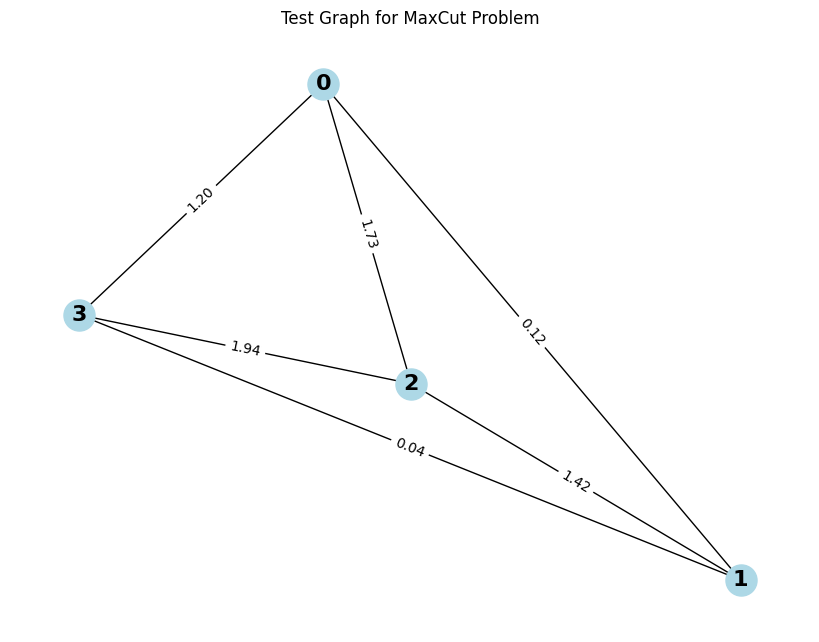

In [7]:
run_maxcut_example()

=== Quantum vs Classical Max-Cut Comparison ===

Graph Type: complete
Nodes: 7
Edges: 21

--- Brute Force (Exact) ---
Best Bitstring: 0101011
Max Cut Value: 11.0612

--- QAOA Solver ---
Best Bitstring Sampled: 0101011
Max Cut Value Sampled: 11.0612

Approximation Ratio: 1.0000

Visualizing solutions...


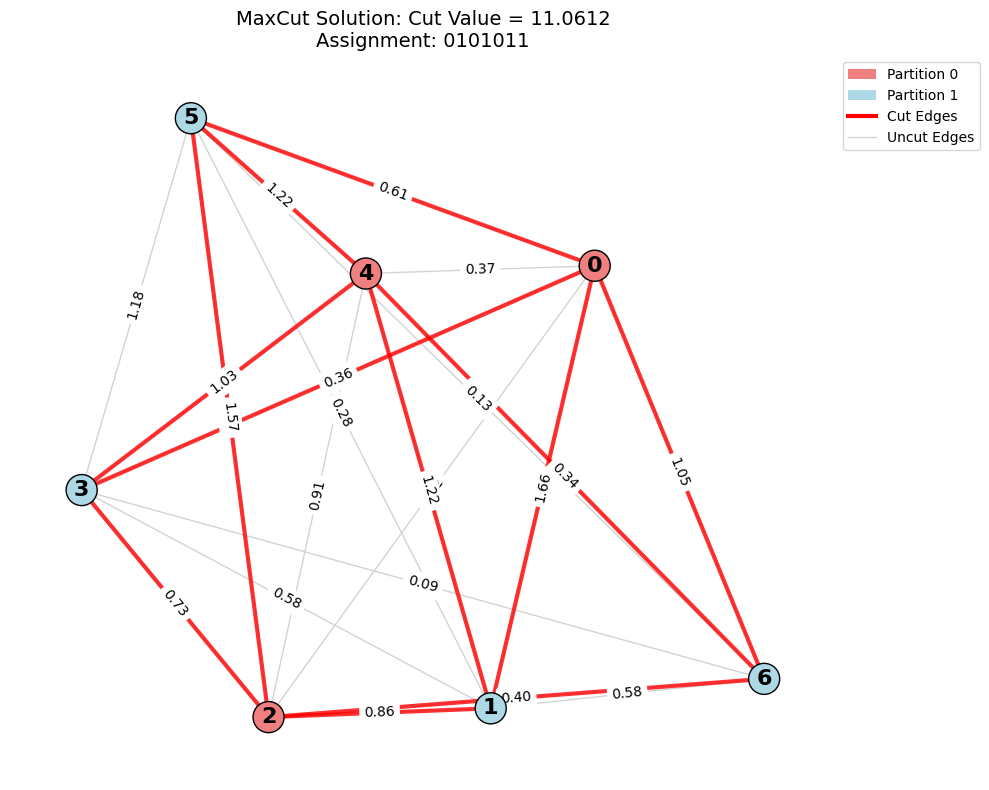

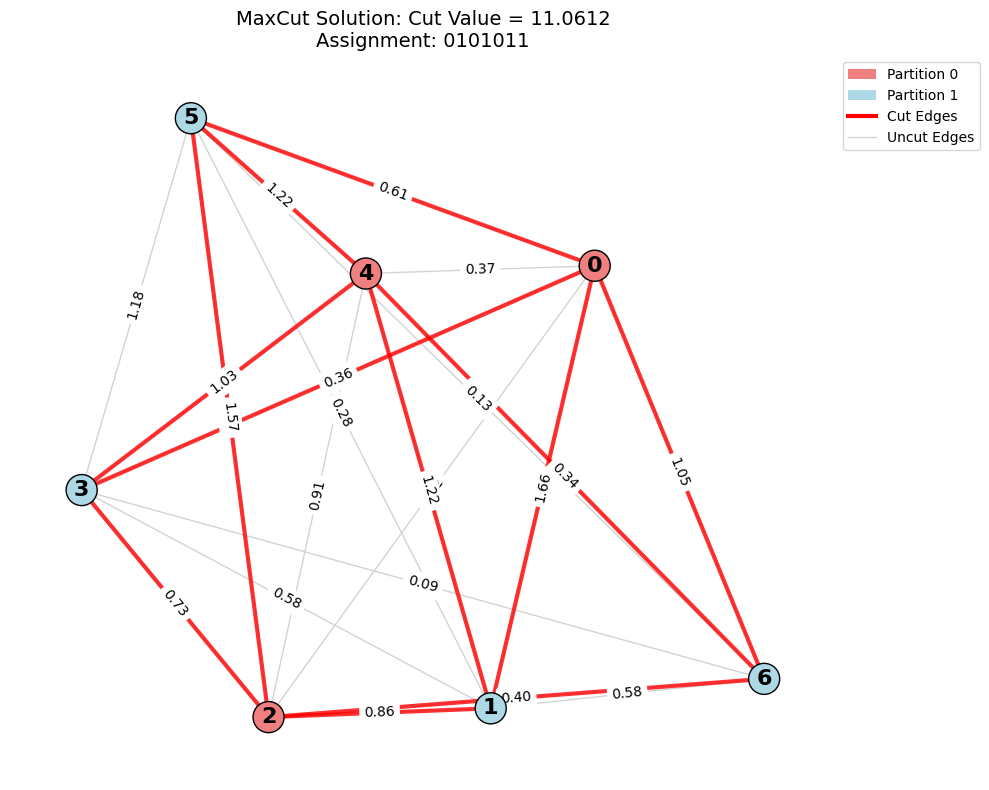

In [8]:
def compare_quantum_vs_bruteforce(num_nodes=6, graph_type='complete', reps=1, max_iter=20):
    print("=== Quantum vs Classical Max-Cut Comparison ===\n")
    
    # Step 1: Create graph
    graph = create_test_graph(num_nodes=num_nodes, graph_type=graph_type)
    
    # Step 2: Solve using brute-force (classical)
    classical_solver = MaxCutBruteForce(graph)
    classical_result = classical_solver.solve(verbose=False)
    
    # Step 3: Solve using QAOA-inspired dynamic ansatz (quantum)
    quantum_solver = MaxCutDynamicSolver(graph, num_reps=reps, max_iterations=max_iter)
    quantum_result = quantum_solver.solve(verbose=False)
    
    # Step 4: Sample from the quantum circuit to extract bitstring
    cut_values = quantum_solver.sample_solutions(
        quantum_result['ansatz'],
        quantum_result['parameters'],
        shots=1024
    )
    
    # Find best bitstring among samples
    best_sample = max(cut_values.items(), key=lambda x: x[1]['cut_value'])
    best_bitstring = best_sample[0]
    best_cut_value = best_sample[1]['cut_value']
    
    # Step 5: Print comparison
    print(f"Graph Type: {graph_type}")
    print(f"Nodes: {num_nodes}")
    print(f"Edges: {len(graph.edges())}")
    print("\n--- Brute Force (Exact) ---")
    print(f"Best Bitstring: {classical_result['bitstring']}")
    print(f"Max Cut Value: {classical_result['cut_value']:.4f}")
    
    print("\n--- QAOA Solver ---")
    print(f"Best Bitstring Sampled: {best_bitstring}")
    print(f"Max Cut Value Sampled: {best_cut_value:.4f}")
    
    # Step 6: Approximation ratio
    ratio = best_cut_value / classical_result['cut_value']
    print(f"\nApproximation Ratio: {ratio:.4f}")
    
    # Optional: visualize both
    print("\nVisualizing solutions...")
    classical_solver.visualize_solution()
    quantum_solver.graph = graph  # Ensure same reference
    classical_solver.visualize_solution(assignment=[int(b) for b in best_bitstring])

    
    return {
        'classical_cut': classical_result['cut_value'],
        'quantum_cut': best_cut_value,
        'approximation_ratio': ratio,
        'bitstring_quantum': best_bitstring,
        'bitstring_classical': classical_result['bitstring'],
        'Quantum Solver': quantum_solver,
        'Graph': graph
    }

# Run comparison
results = compare_quantum_vs_bruteforce(num_nodes=7, graph_type='complete', reps=1, max_iter=40)


In [9]:
results

{'classical_cut': 11.0611583936224,
 'quantum_cut': 11.0611583936224,
 'approximation_ratio': 1.0,
 'bitstring_quantum': '0101011',
 'bitstring_classical': '0101011',
 'Quantum Solver': <__main__.MaxCutDynamicSolver at 0x229d7021310>,
 'Graph': <networkx.classes.graph.Graph at 0x229d6fd82b0>}

In [14]:
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estmiator
from scipy.optimize import minimize
import numpy as np

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator"""
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

def solve_with_su2_ansatz(graph, p=1, maxiter=50):
    """
    Solves the Max-Cut problem using a fixed SU(2)-like TwoLocal ansatz.

    Parameters:
        graph (networkx.Graph): The input graph.
        p (int): Number of layers.
        maxiter (int): Maximum number of optimizer iterations.

    Returns:
        dict: Best bitstring, best cut value, and intermediate values.
    """
    n_qubits = graph.number_of_nodes()
    edges = list(graph.edges(data='weight', default=1))

    # Cost Hamiltonian construction
    hamiltonian = sum(
        weight * SparsePauliOp.from_list(
            [(f'Z{i} Z{j}', 1.0)]
        ) for i, j, weight in edges
    )

    # SU(2)-like TwoLocal ansatz
    ansatz = TwoLocal(n_qubits, rotation_blocks='ry', entanglement_blocks='cz',
                      entanglement='full', reps=p, parameter_prefix='θ')

    estimator = Estimator()
    x0 = np.random.uniform(0, 2 * np.pi, ansatz.num_parameters)

    def objective(params):
        return cost_func(params, ansatz, hamiltonian, estimator)

    result = minimize(
        objective, x0, method="COBYLA"
        )

    best_params = result.x
    qc = ansatz.bind_parameters(best_params)
    counts = estimator.run([(qc, hamiltonian)]).result()[0].data

    # Max-Cut value from minimum energy (cut = -(energy) + constant offset if normalized)
    best_cut_value = -result.fun  # since max cut ↔ min energy
    return {
        'cut_value': best_cut_value,
        'parameters': best_params,
        'optimizer_result': result
    }


In [ ]:
# Use the same graph as before
graph = results['Graph']

# Solve using SU(2) ansatz
su2_results = solve_with_su2_ansatz(graph, p=1, maxiter=50)

# Display results
print("\n--- SU(2) Ansatz Results ---")
print(f"Best Bitstring (SU2): {su2_results['bitstring']}")
print(f"Max-Cut Value (SU2): {su2_results['cut_value']:.4f}")
print(f"Function Eval Count: {su2_results['nfev']}")


QiskitError: 'Pauli string label "Z0 Z1" is not valid.'

: 